In [1]:
import gc  
import os  
import time  
import warnings 
from itertools import combinations  
from warnings import simplefilter 
import joblib  
# import lightgbm as lgb  
import numpy as np
import pandas as pd  
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import KFold, TimeSeriesSplit  
import polars as pl
import numpy as np
import importlib
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler


import numpy as np
from sklearn.metrics import mean_absolute_error
import gc
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping


warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

is_offline = True 
LGB = False
NN = True
is_train = True  
is_infer = True 
max_lookback = np.nan 
split_day = 435  


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Data preprocessing was taken from: https://www.kaggle.com/code/peizhengwang/best-public-scores

# **Utilities**

In [2]:
def symmetric_range(data, percentile):
    # Calculate percentiles
    lower_bound = np.percentile(data[~np.isnan(data)], percentile/2)
    upper_bound = np.percentile(data[~np.isnan(data)], 100-(percentile/2))

    # Display ranges
    return lower_bound, upper_bound

def outlier_info(df, col, verbose = True):
    p = 3
    if verbose:
        print(f"{'='*10} {col} {'='*10}")
        print(f"std: " + str(round(df[col].std(), p)))
        print(f"mean: " + str(round(df[col].mean(), p)))
        print(f"median: " + str(round(df[col].median(), p)))
        print(f"skew: " + str(round(df[col].skew(), p)))
        print(f"kurtosis: " + str(round(df[col].kurtosis(), p)))
        print(f"{'='*2} range {'='*2}")
    res = {}
    for c in [0, 1, 5, 12.5, 25]:
        l, u = symmetric_range(df[col].values, c)
        res[c] = (l, u)
        if verbose:
            print(f"{100-c}%\t{round(l, p)}\t—  {round(u, p)}")
    if verbose:
        print("\n\n")
    return res

def replace_outliers_by_critical(col, bottom_val, top_val):
    cnt = ((col < bottom_val) | (col > top_val)).sum()
    print(f"updates values: {cnt}")
    col.loc[col < bottom_val] = bottom_val
    col.loc[col > top_val] = top_val
    return col

def to_xy(df, X_cols):
    num_stocks = df["stock_id"].nunique()
    num_dates = df["date_id"].nunique()
    num_updates = df["seconds_in_bucket"].nunique()
    dates_map = { date: index for index, date in enumerate(np.sort(df["date_id"].unique()))}
    
    X = np.empty((num_stocks, num_dates, num_updates, len(X_cols)))
    y = np.empty((num_stocks, num_dates, num_updates))
    cnt = 0
    for (date_id, stock_id), frame in tqdm(df.groupby(['date_id', 'stock_id'])):
        date_index = dates_map[date_id]
        X[stock_id,date_index] = frame[X_cols]
        y[stock_id,date_index] = frame['target']
    return X, y


In [3]:
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return w

In [4]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [5]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
               
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df


# Data Loading






In [6]:
# df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")
df = pd.read_parquet("/kaggle/input/df-preproc/df_preproc.pkl")
df = df.dropna(subset=["target", "wap"])
df.reset_index(drop=True, inplace=True)
df_shape = df.shape

**Outlier removal**

 # Parallel Triplet Imbalance Calculation

In [8]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features


# Feature Generation Functions 

In [9]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)
   
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1,3,5,10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'weighted_wap','price_spread']:
        for window in [1,3,5,10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)
    
    #V4 feature
    for window in [3,5,10]:
        df[f'price_change_diff_{window}'] = df[f'bid_price_diff_{window}'] - df[f'ask_price_diff_{window}']
        df[f'size_change_diff_{window}'] = df[f'bid_size_diff_{window}'] - df[f'ask_size_diff_{window}']

    #V5 - rolling diff
    # Convert from pandas to Polars
    pl_df = pl.from_pandas(df)

    #Define the windows and columns for which you want to calculate the rolling statistics
    windows = [3, 5, 10]
    columns = ['ask_price', 'bid_price', 'ask_size', 'bid_size']

    # prepare the operations for each column and window
    group = ["stock_id"]
    expressions = []

    # Loop over each window and column to create the rolling mean and std expressions
    for window in windows:
        for col in columns:
            rolling_mean_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_mean(window)
                .over(group)
                .alias(f'rolling_diff_{col}_{window}')
            )

            rolling_std_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_std(window)
                .over(group)
                .alias(f'rolling_std_diff_{col}_{window}')
            )

            expressions.append(rolling_mean_expr)
            expressions.append(rolling_std_expr)

    # Run the operations using Polars' lazy API
    lazy_df = pl_df.lazy().with_columns(expressions)

    # Execute the lazy expressions and overwrite the pl_df variable
    pl_df = lazy_df.collect()

    # Convert back to pandas if necessary
    df = pl_df.to_pandas()
    gc.collect()
    
    df['mid_price*volume'] = df['mid_price_movement'] * df['volume']
    df['harmonic_imbalance'] = df.eval('2 / ((1 / bid_size) + (1 / ask_size))')
    
    for col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], 0)

    return df

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60  
    df['time_to_market_close'] = 540 - df['seconds_in_bucket']
    
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id"]]
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    gc.collect() 
    df = other_features(df)
    gc.collect()  
    feature_name = [i for i in df.columns if i not in ["row_id", "time_id"]]
    
    return df[feature_name]


In [10]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

In [11]:
def null_cnts(df):
    null_cnts = df.isna().sum()

    low_null_features_series = null_cnts[null_cnts < 500]
    for i in low_null_features_series.items():
        print(i)

    low_null_features = low_null_features_series.index
    return low_null_features

def show_hists(df, cols = None, figsize = None, plot_cols = 3, bins=100):
    if cols is not None:
        df = df[cols]
    if figsize is None:
        figsize = (12, 20)
    # Calculating the number of rows and columns needed for subplots
    num_cols = len(df.columns)
    num_rows = (num_cols // plot_cols) + 1 # Ensures proper layout for odd number of columns

    # Creating subplots
    fig, axes = plt.subplots(num_rows, plot_cols, figsize=figsize)  # Adjust figsize as needed

    # Flatten axes if more than one row
    axes = axes.flatten()

    # Plotting each column in a separate subplot
    for i, col in enumerate(df.columns):
        df[col].hist(ax=axes[i], bins=bins)
        axes[i].set_title(col)  # Setting Y-axis label

    # Hiding any unused subplots
    for i in range(num_cols, len(axes)):
        axes[i].axis('off')

    # Adjusting layout
    plt.tight_layout()
    plt.show()

In [12]:

features = [
    'seconds_in_bucket',
    'imbalance_size',
    'imbalance_buy_sell_flag',
    'reference_price',
    'matched_size',
    'far_price',
    'near_price',
    'bid_price',
    'bid_size',
    'ask_price',
    'ask_size',
    'wap',
    'volume',
    'mid_price',
    'liquidity_imbalance',
    'matched_imbalance',
    'size_imbalance',
    'reference_price_far_price_imb',
    'reference_price_near_price_imb',
    'reference_price_ask_price_imb',
    'reference_price_bid_price_imb',
    'reference_price_wap_imb',
    'far_price_near_price_imb',
    'far_price_ask_price_imb',
    'far_price_bid_price_imb',
    'far_price_wap_imb',
    'near_price_ask_price_imb',
    'near_price_bid_price_imb',
    'near_price_wap_imb',
    'ask_price_bid_price_imb',
    'ask_price_wap_imb',
    'bid_price_wap_imb',
    'ask_price_bid_price_wap_imb2',
    'ask_price_bid_price_reference_price_imb2',
    'ask_price_wap_reference_price_imb2',
    'bid_price_wap_reference_price_imb2',
    'matched_size_bid_size_ask_size_imb2',
    'matched_size_bid_size_imbalance_size_imb2',
    'matched_size_ask_size_imbalance_size_imb2',
    'bid_size_ask_size_imbalance_size_imb2',
    'stock_weights',
    'weighted_wap',
    'wap_momentum',
    'imbalance_momentum',
    'price_spread',
    'spread_intensity',
    'price_pressure',
    'market_urgency',
    'depth_pressure',
    'spread_depth_ratio',
    'mid_price_movement',
    'micro_price',
    'relative_spread',
    'all_prices_mean',
    'all_sizes_mean',
    'all_prices_std',
    'all_sizes_std',
    'all_prices_skew',
    'all_sizes_skew',
    'all_prices_kurt',
    'all_sizes_kurt',
    'matched_size_shift_1',
    'matched_size_ret_1',
    'matched_size_shift_3',
    'matched_size_ret_3',
    'matched_size_shift_5',
    'matched_size_ret_5',
    'matched_size_shift_10',
    'matched_size_ret_10',
    'imbalance_size_shift_1',
    'imbalance_size_ret_1',
    'imbalance_size_shift_3',
    'imbalance_size_ret_3',
    'imbalance_size_shift_5',
    'imbalance_size_ret_5',
    'imbalance_size_shift_10',
    'imbalance_size_ret_10',
    'reference_price_shift_1',
    'reference_price_ret_1',
    'reference_price_shift_3',
    'reference_price_ret_3',
    'reference_price_shift_5',
    'reference_price_ret_5',
    'reference_price_shift_10',
    'reference_price_ret_10',
    'imbalance_buy_sell_flag_shift_1',
    'imbalance_buy_sell_flag_ret_1',
    'imbalance_buy_sell_flag_shift_3',
    'imbalance_buy_sell_flag_ret_3',
    'imbalance_buy_sell_flag_shift_5',
    'imbalance_buy_sell_flag_ret_5',
    'imbalance_buy_sell_flag_shift_10',
    'imbalance_buy_sell_flag_ret_10',
    'ask_price_diff_1',
    'ask_price_diff_3',
    'ask_price_diff_5',
    'ask_price_diff_10',
    'bid_price_diff_1',
    'bid_price_diff_3',
    'bid_price_diff_5',
    'bid_price_diff_10',
    'ask_size_diff_1',
    'ask_size_diff_3',
    'ask_size_diff_5',
    'ask_size_diff_10',
    'bid_size_diff_1',
    'bid_size_diff_3',
    'bid_size_diff_5',
    'bid_size_diff_10',
    'weighted_wap_diff_1',
    'weighted_wap_diff_3',
    'weighted_wap_diff_5',
    'weighted_wap_diff_10',
    'price_spread_diff_1',
    'price_spread_diff_3',
    'price_spread_diff_5',
    'price_spread_diff_10',
    'price_change_diff_3',
    'size_change_diff_3',
    'price_change_diff_5',
    'size_change_diff_5',
    'price_change_diff_10',
    'size_change_diff_10',
    'rolling_diff_ask_price_3',
    'rolling_std_diff_ask_price_3',
    'rolling_diff_bid_price_3',
    'rolling_std_diff_bid_price_3',
    'rolling_diff_ask_size_3',
    'rolling_std_diff_ask_size_3',
    'rolling_diff_bid_size_3',
    'rolling_std_diff_bid_size_3',
    'rolling_diff_ask_price_5',
    'rolling_std_diff_ask_price_5',
    'rolling_diff_bid_price_5',
    'rolling_std_diff_bid_price_5',
    'rolling_diff_ask_size_5',
    'rolling_std_diff_ask_size_5',
    'rolling_diff_bid_size_5',
    'rolling_std_diff_bid_size_5',
    'rolling_diff_ask_price_10',
    'rolling_std_diff_ask_price_10',
    'rolling_diff_bid_price_10',
    'rolling_std_diff_bid_price_10',
    'rolling_diff_ask_size_10',
    'rolling_std_diff_ask_size_10',
    'rolling_diff_bid_size_10',
    'rolling_std_diff_bid_size_10',
    'mid_price*volume',
    'harmonic_imbalance',
    'dow',
    'time_to_market_close',
    'global_median_size',
    'global_std_size',
    'global_ptp_size',
    'global_median_price',
    'global_std_price',
    'global_ptp_price'
]

## Data Splitting

In [13]:
if is_offline:
    
    df_train = df[df["date_id"] <= split_day]
    df_valid = df[df["date_id"] > split_day]
    print("Offline mode")
    print(f"train : {df_train.shape}, valid : {df_valid.shape}")
    
else:
    df_train = df
    print("Online mode")


Offline mode
train : (4742815, 17), valid : (494945, 17)


In [14]:
if is_train:
    global_stock_id_feats = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }
    if is_offline:
        df_train_feats = generate_all_features(df_train)
        print("Build Train Feats Finished.")
        df_valid_feats = generate_all_features(df_valid)
        print("Build Valid Feats Finished.")
        df_valid_feats = reduce_mem_usage(df_valid_feats)
    else:
        df_train_feats = generate_all_features(df_train)
        print("Build Online Train Feats Finished.")

    df_train_feats = reduce_mem_usage(df_train_feats)


Build Train Feats Finished.
Build Valid Feats Finished.


# **Model Training**

In [15]:
df_train_feats_ = df_train_feats.copy()
df_valid_feats_ = df_valid_feats.copy()

In [16]:
low_null_features = null_cnts(df_train_feats[features])
len(low_null_features)

('seconds_in_bucket', 0)
('imbalance_size', 0)
('imbalance_buy_sell_flag', 0)
('reference_price', 0)
('matched_size', 0)
('bid_price', 0)
('bid_size', 0)
('ask_price', 0)
('ask_size', 0)
('wap', 0)
('volume', 0)
('mid_price', 0)
('liquidity_imbalance', 0)
('matched_imbalance', 0)
('size_imbalance', 0)
('reference_price_wap_imb', 309)
('ask_price_bid_price_imb', 0)
('ask_price_wap_imb', 61)
('bid_price_wap_imb', 76)
('matched_size_bid_size_imbalance_size_imb2', 1)
('matched_size_ask_size_imbalance_size_imb2', 1)
('bid_size_ask_size_imbalance_size_imb2', 290)
('stock_weights', 0)
('weighted_wap', 0)
('imbalance_momentum', 200)
('price_spread', 0)
('spread_intensity', 200)
('price_pressure', 0)
('market_urgency', 0)
('spread_depth_ratio', 0)
('mid_price_movement', 0)
('micro_price', 0)
('relative_spread', 0)
('all_prices_mean', 0)
('all_sizes_mean', 0)
('all_prices_std', 0)
('all_sizes_std', 0)
('all_prices_skew', 0)
('all_sizes_skew', 0)
('all_prices_kurt', 0)
('all_sizes_kurt', 0)
('mat

62

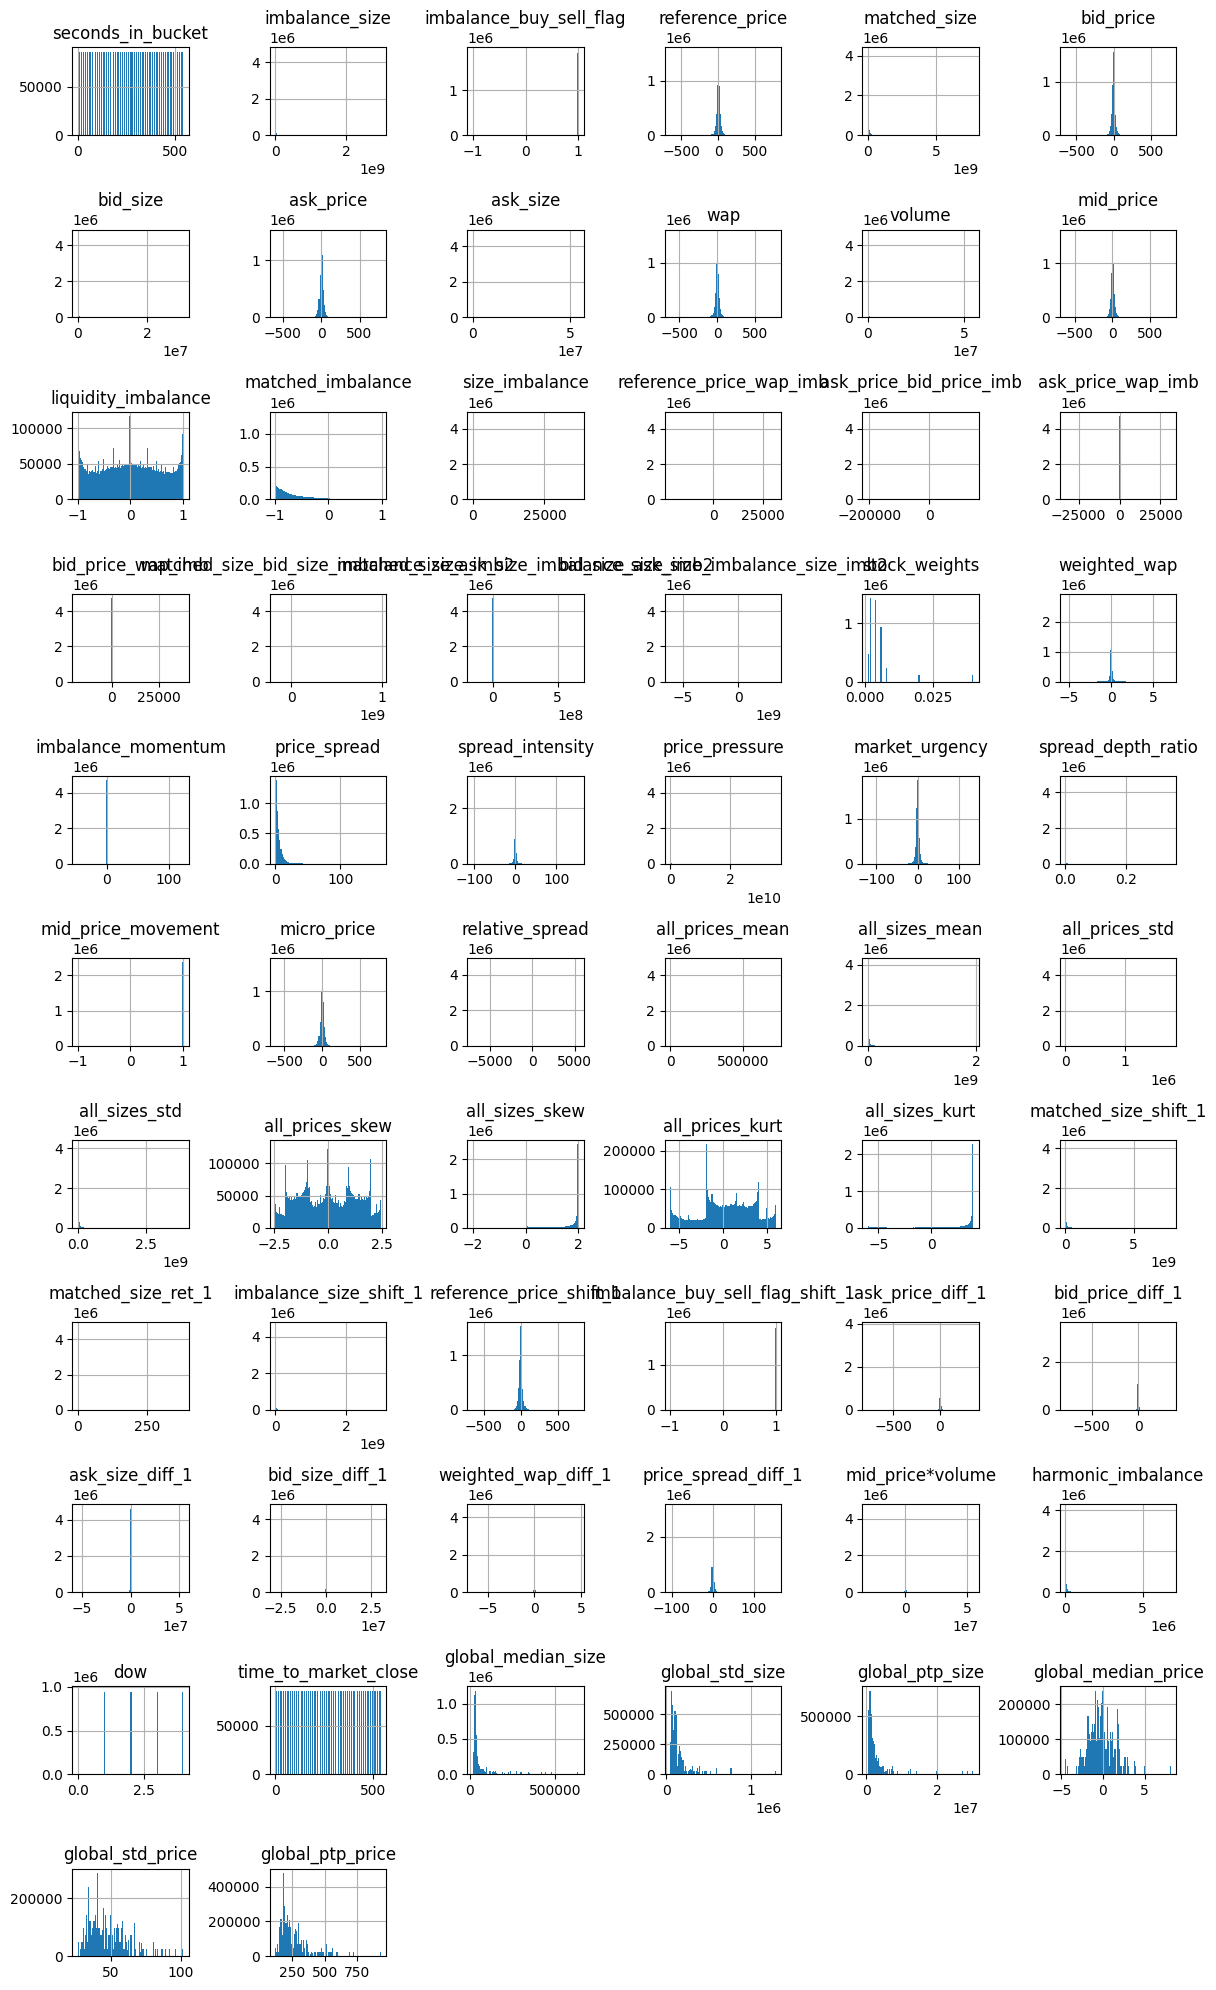

In [17]:
show_hists(df_train_feats, cols = low_null_features, figsize = None, plot_cols = 6)

In [18]:
low_null_means = df_train_feats[low_null_features].mean()

df_train_feats[low_null_features] = df_train_feats[low_null_features].fillna(low_null_means)
df_valid_feats[low_null_features] = df_valid_feats[low_null_features].fillna(low_null_means)

In [20]:
X_train, y_train = to_xy(df_train_feats, low_null_features)
X_valid, y_valid = to_xy(df_valid_feats, low_null_features)

  0%|          | 0/86233 [00:00<?, ?it/s]

  0%|          | 0/8999 [00:00<?, ?it/s]

In [21]:
crop_percent = 2.5

X_train_flat = X_train.reshape(-1, X_train.shape[-1])
for index, col in enumerate(low_null_features):
    print(col, end = ", ")
    a_min, a_max = symmetric_range(X_train_flat[:, index], crop_percent)
    X_train_flat[:, index] = np.clip(X_train_flat[:, index], a_min = a_min, a_max = a_max)
X_train = X_train_flat.reshape(X_train.shape)

seconds_in_bucket, imbalance_size, imbalance_buy_sell_flag, reference_price, matched_size, bid_price, bid_size, ask_price, ask_size, wap, volume, mid_price, liquidity_imbalance, matched_imbalance, size_imbalance, reference_price_wap_imb, ask_price_bid_price_imb, ask_price_wap_imb, bid_price_wap_imb, matched_size_bid_size_imbalance_size_imb2, matched_size_ask_size_imbalance_size_imb2, bid_size_ask_size_imbalance_size_imb2, stock_weights, weighted_wap, imbalance_momentum, price_spread, spread_intensity, price_pressure, market_urgency, spread_depth_ratio, mid_price_movement, micro_price, relative_spread, all_prices_mean, all_sizes_mean, all_prices_std, all_sizes_std, all_prices_skew, all_sizes_skew, all_prices_kurt, all_sizes_kurt, matched_size_shift_1, matched_size_ret_1, imbalance_size_shift_1, reference_price_shift_1, imbalance_buy_sell_flag_shift_1, ask_price_diff_1, bid_price_diff_1, ask_size_diff_1, bid_size_diff_1, weighted_wap_diff_1, price_spread_diff_1, mid_price*volume, harmoni

In [22]:
d = pd.DataFrame(data = X_train.reshape(-1, X_train.shape[-1]), columns = low_null_features)

show_hists(d, cols = low_null_features, figsize = None, plot_cols = 6, bins = 100)

In [23]:
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid_scaled = x_scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)

a_min, a_max = symmetric_range(y_train, crop_percent)
print(a_min, a_max)
y_train = np.clip(y_train, a_min = a_min, a_max=a_max)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)



-25.979877471923828 29.189720749857038


In [24]:
import gc
gc.collect()

524279

## Model v1, MAE: 5.92

In [18]:
learning_rate = 0.01
time_slots = 55

hidden_units = [128, 170, 128, 128]  # Example hidden units
dropout_rates = [0.3, 0.3, 0.3, 0.3]  # Example dropout rates

input_continuous = tf.keras.layers.Input(shape=(time_slots, len(low_null_features)))
x = input_continuous


for i in range(len(hidden_units)):
    x = tf.keras.layers.LSTM(hidden_units[i], 
                             activation='tanh',
                             recurrent_activation='sigmoid',
                             return_sequences=True, 
#                              kernel_regularizer=l2(0.1), 
#                              recurrent_regularizer=l2(.1),
#                              kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=.1),
#                              recurrent_constraint=tf.keras.constraints.MinMaxNorm(min_value=.1)
                            )(x)
    x = tf.keras.layers.Dropout(dropout_rates[i])(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(x)
model = tf.keras.models.Model(inputs=input_continuous, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(), #
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 55, 136)]         0         
                                                                 
 lstm (LSTM)                 (None, 55, 128)           135680    
                                                                 
 dropout (Dropout)           (None, 55, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 55, 128)           512       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 55, 170)           203320    
                                                                 
 dropout_1 (Dropout)         (None, 55, 170)           0         
                                                             

In [32]:
X_train_all = X_train_scaled.reshape(-1, *X_train.shape[2:])
y_train_all = y_train_scaled.reshape(-1, *y_train.shape[2:])

X_valid_all = X_valid_scaled.reshape(-1, *X_valid.shape[2:])
y_valid_all = y_valid_scaled.reshape(-1, *y_valid.shape[2:])

In [33]:
import math
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(range(len(X_train_all)), test_size=0.2, random_state=42)


X_train_split = X_train_all[train_indices]
X_val_split = X_train_all[test_indices]
y_train_split = y_train_all[train_indices]
y_val_split = y_train_all[test_indices]


rlr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1, patience=2, verbose=0, min_delta=1e-3, mode='min')
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=1e-4, patience=4, mode='min', restore_best_weights=True, verbose=0)
history = model.fit(X_train_split, y_train_split, batch_size = 64,
          epochs = 10,
          validation_data = (X_val_split, y_val_split),
          callbacks = [rlr, es])

Epoch 1/10
1090/1090 [==============================] - 37s 23ms/step - loss: 1.0124 - mean_absolute_error: 0.7311 - val_loss: 0.9712 - val_mean_absolute_error: 0.7139 - lr: 0.0010
Epoch 2/10
1090/1090 [==============================] - 23s 21ms/step - loss: 0.9617 - mean_absolute_error: 0.7085 - val_loss: 0.9604 - val_mean_absolute_error: 0.7087 - lr: 0.0010
Epoch 3/10
1090/1090 [==============================] - 22s 21ms/step - loss: 0.9579 - mean_absolute_error: 0.7069 - val_loss: 0.9600 - val_mean_absolute_error: 0.7068 - lr: 0.0010
Epoch 4/10
1090/1090 [==============================] - 23s 21ms/step - loss: 0.9540 - mean_absolute_error: 0.7054 - val_loss: 0.9570 - val_mean_absolute_error: 0.7062 - lr: 0.0010
Epoch 5/10
1090/1090 [==============================] - 23s 21ms/step - loss: 0.9516 - mean_absolute_error: 0.7045 - val_loss: 0.9585 - val_mean_absolute_error: 0.7076 - lr: 0.0010
Epoch 6/10
1090/1090 [==============================] - 23s 21ms/step - loss: 0.9435 - mean_abs

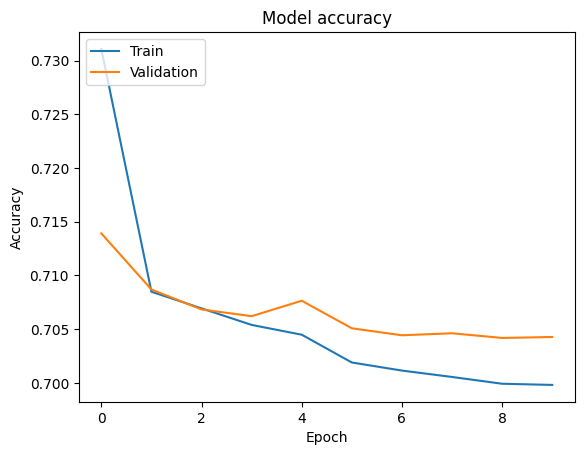

In [34]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
y_pred = model.predict(X_valid_all)
y_pred = y_pred.reshape(y_pred.shape[:-1])

y_pred = y_scaler.inverse_transform(y_pred)



282/282 [==============================] - 4s 8ms/step


In [36]:
y_pred = np.nan_to_num(y_pred, nan=0.)

5.92061919346444


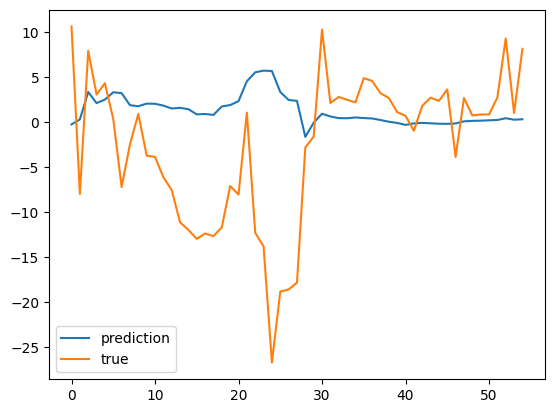

In [37]:
index = 5000
plt.plot(y_pred[index], label="prediction")
plt.plot(y_valid.reshape(-1, y_valid.shape[-1])[index], label="true")

print(mean_absolute_error(y_valid.reshape(y_pred.shape), y_pred))
plt.legend()
plt.show()

In [38]:
gc.collect()

255

# ## Model v2, More features with masking null values:

In [49]:
df_train_feats = df_train_feats_.copy()
df_valid_feats = df_valid_feats_.copy()

In [19]:
gc.collect()

32958

In [22]:
# df_train_feats[(df_train_feats['stock_id'] == 0) & (df_train_feats['date_id'] == 0)]
low_null_features = null_cnts(df_train_feats[(df_train_feats['seconds_in_bucket'] >= 300)][features])

('seconds_in_bucket', 0)
('imbalance_size', 0)
('imbalance_buy_sell_flag', 0)
('reference_price', 0)
('matched_size', 0)
('near_price', 0)
('bid_price', 0)
('bid_size', 0)
('ask_price', 0)
('ask_size', 0)
('wap', 0)
('volume', 0)
('mid_price', 0)
('liquidity_imbalance', 0)
('matched_imbalance', 0)
('size_imbalance', 0)
('reference_price_bid_price_imb', 451)
('reference_price_wap_imb', 10)
('near_price_ask_price_imb', 238)
('near_price_bid_price_imb', 180)
('near_price_wap_imb', 2)
('ask_price_bid_price_imb', 0)
('ask_price_wap_imb', 5)
('bid_price_wap_imb', 6)
('matched_size_bid_size_ask_size_imb2', 180)
('matched_size_bid_size_imbalance_size_imb2', 0)
('matched_size_ask_size_imbalance_size_imb2', 0)
('bid_size_ask_size_imbalance_size_imb2', 31)
('stock_weights', 0)
('weighted_wap', 0)
('wap_momentum', 1)
('imbalance_momentum', 0)
('price_spread', 0)
('spread_intensity', 0)
('price_pressure', 0)
('market_urgency', 0)
('spread_depth_ratio', 0)
('mid_price_movement', 0)
('micro_price', 0

In [43]:
X_train, y_train = to_xy(df_train_feats, low_null_features)
X_valid, y_valid = to_xy(df_valid_feats, low_null_features)

  0%|          | 0/86233 [00:00<?, ?it/s]

  0%|          | 0/8999 [00:00<?, ?it/s]

In [20]:
gc.collect()

73

In [21]:
low_null_features = ["seconds_in_bucket","imbalance_size","imbalance_buy_sell_flag","reference_price","matched_size","near_price","bid_price","bid_size","ask_price","ask_size","wap","volume","mid_price","liquidity_imbalance","matched_imbalance","size_imbalance","reference_price_bid_price_imb","reference_price_wap_imb","near_price_ask_price_imb","near_price_bid_price_imb","near_price_wap_imb","ask_price_bid_price_imb","ask_price_wap_imb","bid_price_wap_imb","matched_size_bid_size_ask_size_imb2","matched_size_bid_size_imbalance_size_imb2","matched_size_ask_size_imbalance_size_imb2","bid_size_ask_size_imbalance_size_imb2","stock_weights","weighted_wap","wap_momentum","imbalance_momentum","price_spread","spread_intensity","price_pressure","market_urgency","spread_depth_ratio","mid_price_movement","micro_price","relative_spread","all_prices_mean","all_sizes_mean","all_prices_std","all_sizes_std","all_prices_skew","all_sizes_skew","all_prices_kurt","all_sizes_kurt","matched_size_shift_1","matched_size_ret_1","matched_size_shift_3","matched_size_ret_3","matched_size_shift_5","matched_size_ret_5","matched_size_shift_10","matched_size_ret_10","imbalance_size_shift_1","imbalance_size_shift_3","imbalance_size_shift_5","imbalance_size_shift_10","reference_price_shift_1","reference_price_ret_1","reference_price_shift_3","reference_price_ret_3","reference_price_shift_5","reference_price_ret_5","reference_price_shift_10","reference_price_ret_10","imbalance_buy_sell_flag_shift_1","imbalance_buy_sell_flag_shift_3","imbalance_buy_sell_flag_shift_5","imbalance_buy_sell_flag_shift_10","ask_price_diff_1","ask_price_diff_3","ask_price_diff_5","ask_price_diff_10","bid_price_diff_1","bid_price_diff_3","bid_price_diff_5","bid_price_diff_10","ask_size_diff_1","ask_size_diff_3","ask_size_diff_5","ask_size_diff_10","bid_size_diff_1","bid_size_diff_3","bid_size_diff_5","bid_size_diff_10","weighted_wap_diff_1","weighted_wap_diff_3","weighted_wap_diff_5","weighted_wap_diff_10","price_spread_diff_1","price_spread_diff_3","price_spread_diff_5","price_spread_diff_10","price_change_diff_3","size_change_diff_3","price_change_diff_5","size_change_diff_5","price_change_diff_10","size_change_diff_10","rolling_diff_ask_price_3","rolling_std_diff_ask_price_3","rolling_diff_bid_price_3","rolling_std_diff_bid_price_3","rolling_diff_ask_size_3","rolling_std_diff_ask_size_3","rolling_diff_bid_size_3","rolling_std_diff_bid_size_3","rolling_diff_ask_price_5","rolling_std_diff_ask_price_5","rolling_diff_bid_price_5","rolling_std_diff_bid_price_5","rolling_diff_ask_size_5","rolling_std_diff_ask_size_5","rolling_diff_bid_size_5","rolling_std_diff_bid_size_5","rolling_diff_ask_price_10","rolling_std_diff_ask_price_10","rolling_diff_bid_price_10","rolling_std_diff_bid_price_10","rolling_diff_ask_size_10","rolling_std_diff_ask_size_10","rolling_diff_bid_size_10","rolling_std_diff_bid_size_10","mid_price*volume","harmonic_imbalance","dow","time_to_market_close","global_median_size","global_std_size","global_ptp_size","global_median_price","global_std_price","global_ptp_price"]

In [22]:
crop_percent = 1

for index, col in enumerate(low_null_features):
    print(col, end = ", ")
    a_min, a_max = symmetric_range(X_train[:, :, :, index], crop_percent)
    X_train[:, :, :, index] = np.clip(X_train[:, :, :, index], a_min = a_min, a_max = a_max)

seconds_in_bucket, imbalance_size, imbalance_buy_sell_flag, reference_price, matched_size, near_price, bid_price, bid_size, ask_price, ask_size, wap, volume, mid_price, liquidity_imbalance, matched_imbalance, size_imbalance, reference_price_bid_price_imb, reference_price_wap_imb, near_price_ask_price_imb, near_price_bid_price_imb, near_price_wap_imb, ask_price_bid_price_imb, ask_price_wap_imb, bid_price_wap_imb, matched_size_bid_size_ask_size_imb2, matched_size_bid_size_imbalance_size_imb2, matched_size_ask_size_imbalance_size_imb2, bid_size_ask_size_imbalance_size_imb2, stock_weights, weighted_wap, wap_momentum, imbalance_momentum, price_spread, spread_intensity, price_pressure, market_urgency, spread_depth_ratio, mid_price_movement, micro_price, relative_spread, all_prices_mean, all_sizes_mean, all_prices_std, all_sizes_std, all_prices_skew, all_sizes_skew, all_prices_kurt, all_sizes_kurt, matched_size_shift_1, matched_size_ret_1, matched_size_shift_3, matched_size_ret_3, matched_siz

In [23]:
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid_scaled = x_scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)

a_min, a_max = symmetric_range(y_train, crop_percent)
# print(a_min, a_max)
y_train = np.clip(y_train, a_min = a_min, a_max=a_max)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)


In [35]:
mask_val = np.finfo(np.float32).min
n_features = len(low_null_features)

learning_rate = 0.1
time_steps = 55

hidden_units = [128, 128, 128, 128, 128, 128]  # Example hidden units
dropout_rates = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]  # Example dropout rates

input_continuous = tf.keras.layers.Input(shape=(time_steps, n_features))
x = input_continuous

x = tf.keras.layers.Masking(mask_value=mask_val, input_shape=(time_steps, n_features))(x)

for i in range(len(hidden_units)):
    x = tf.keras.layers.LSTM(hidden_units[i], 
                             activation='tanh',
                             recurrent_activation='sigmoid',
                             return_sequences=True,
                             kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=.2),
                             recurrent_constraint=tf.keras.constraints.MinMaxNorm(min_value=.2)
                            )(x)
    x = tf.keras.layers.Dropout(dropout_rates[i])(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(x)
model = tf.keras.models.Model(inputs=input_continuous, outputs=out)
huber_loss = tf.keras.losses.Huber(delta=1.0)

model.compile(optimizer=tf.keras.optimizers.Adam(), #
              loss=huber_loss,
              metrics=['mean_absolute_error'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 55, 136)]         0         
                                                                 
 masking_2 (Masking)         (None, 55, 136)           0         
                                                                 
 lstm_9 (LSTM)               (None, 55, 128)           135680    
                                                                 
 dropout_8 (Dropout)         (None, 55, 128)           0         
                                                                 
 batch_normalization_8 (Bat  (None, 55, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_10 (LSTM)              (None, 55, 128)           131584    
                                                           

In [36]:
X_train_all = X_train_scaled.reshape(-1, *X_train_scaled.shape[2:])
y_train_all = y_train_scaled.reshape(-1, *y_train_scaled.shape[2:], 1)

X_valid_all = X_valid_scaled.reshape(-1, *X_valid_scaled.shape[2:])
y_valid_all = y_valid.reshape(-1, *y_valid.shape[2:], 1)

In [37]:
import math
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(range(len(X_train_all)), test_size=0.2, random_state=42)


X_train_split = X_train_all[train_indices]
X_val_split = X_train_all[test_indices]
y_train_split = y_train_all[train_indices]
y_val_split = y_train_all[test_indices]
X_train_split.shape, y_train_split.shape

((69760, 55, 136), (69760, 55, 1))

In [38]:
gc.collect()

69584

In [39]:
X_train_split[np.isnan(X_train_split)] = mask_val
X_val_split[np.isnan(X_val_split)] = mask_val

In [40]:
rlr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1, patience=2, verbose=0, min_delta=1e-3, mode='min')
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=1e-4, patience=4, mode='min', restore_best_weights=True, verbose=0)
history = model.fit(X_train_split, y_train_split, 
          batch_size = 64,
          epochs = 10,
          validation_data = (X_val_split, y_val_split),
          callbacks = [rlr, es]
                   )

Epoch 1/10
1090/1090 [==============================] - 68s 45ms/step - loss: 0.4108 - mean_absolute_error: 0.7572 - val_loss: 0.3814 - val_mean_absolute_error: 0.7204 - lr: 0.0010
Epoch 2/10
1090/1090 [==============================] - 40s 36ms/step - loss: 0.3827 - mean_absolute_error: 0.7217 - val_loss: 0.3809 - val_mean_absolute_error: 0.7196 - lr: 0.0010
Epoch 3/10
1090/1090 [==============================] - 40s 36ms/step - loss: 0.3825 - mean_absolute_error: 0.7215 - val_loss: 0.3812 - val_mean_absolute_error: 0.7200 - lr: 0.0010
Epoch 4/10
1090/1090 [==============================] - 40s 37ms/step - loss: 0.3817 - mean_absolute_error: 0.7203 - val_loss: 0.3804 - val_mean_absolute_error: 0.7191 - lr: 1.0000e-04
Epoch 5/10
1090/1090 [==============================] - 40s 36ms/step - loss: 0.3815 - mean_absolute_error: 0.7201 - val_loss: 0.3802 - val_mean_absolute_error: 0.7187 - lr: 1.0000e-04
Epoch 6/10
1090/1090 [==============================] - 40s 36ms/step - loss: 0.3813 - 

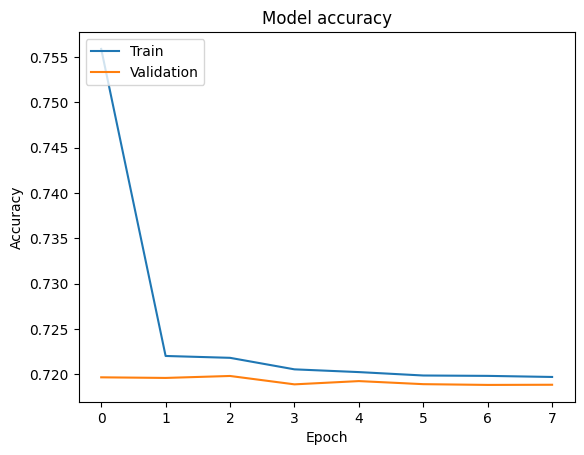

In [31]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
y_pred = model.predict(X_valid_all)
y_pred = y_pred.reshape(y_pred.shape[:-1])

y_pred = y_scaler.inverse_transform(y_pred)

282/282 [==============================] - 11s 13ms/step


In [33]:
y_pred = np.nan_to_num(y_pred, nan=0.)

5.9584837


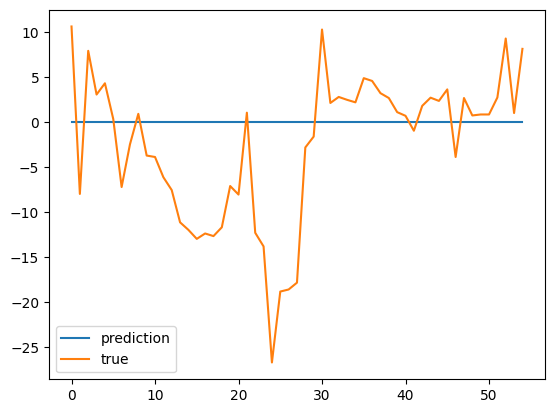

In [41]:
index = 5000
plt.plot(y_pred[index], label="prediction")
plt.plot(y_valid.reshape(-1, y_valid.shape[-1])[index], label="true")

print(mean_absolute_error(y_valid.reshape(y_pred.shape), y_pred))
plt.legend()
plt.show()

In [42]:
print(mean_absolute_error(y_valid.reshape(y_pred.shape), y_pred))

5.9584937
